In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data =  pd.read_json("../../data.json")

cap="tw"
ds = data[data["capture"] ==cap]

ds = ds[(np.array([np.var(s)  <1 for s in ds["a2a1"]]) & np.array([[np.var(s)  <1 for s in ds["a3a2"]]]) & np.array([[np.var(s)  <1 for s in ds["a3a1"]]]))[0].tolist()] 


ds.sample(1)

,index,mac,timestamp,no,rssi,raw,frequency,iq,angle,distance,capture,ref,a1,a2,a3,a2a1,a3a2,a3a1
6828,43,c300000a7a63,2024-10-04 16:10:25.682000+00:00,0,-47,0201061bff3906cafb0114fff9ffe200fd000000000000...,2402,"[-145, 34, 2, -152, 149, 28, -66, 137, -129, -...",60,100.0,tw,"[2.9112709213, -1.5576391913, 0.18575313640000...","[-0.9510583497, -2.5812327767000003, 1.9181133...","[1.2323806487, -0.4863709698, -2.3918936029, 2...","[-2.5206530366, 1.9781653995, 0.1986047491, -1...","[2.1834389983999998, 2.0948618068, 1.973178389...","[2.5301516219, 2.4645363693, 2.590498352, 2.45...","[-1.5695946869, -1.723787131, -1.7195085656, -..."


In [2]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

In [3]:
dt = 1.0/100
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
#kf.update((1,1))

C:\Users\pedro\AppData\Local\Temp\ipykernel_8672\3691588956.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for sample in ds[ds["angle"] ==  angle][ds["distance"] == distance].iterrows():
C:\Users\pedro\AppData\Local\Temp\ipykernel_8672\3691588956.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,sample in enumerate(ds[ds["angle"] ==  angle][ds["distance"] == distance].iterrows()):


Text(0.5, 0.98, "Diferenças de fase na captura 'tw' a 15\n Distancias: [100.0, 150.0, 200.0]")

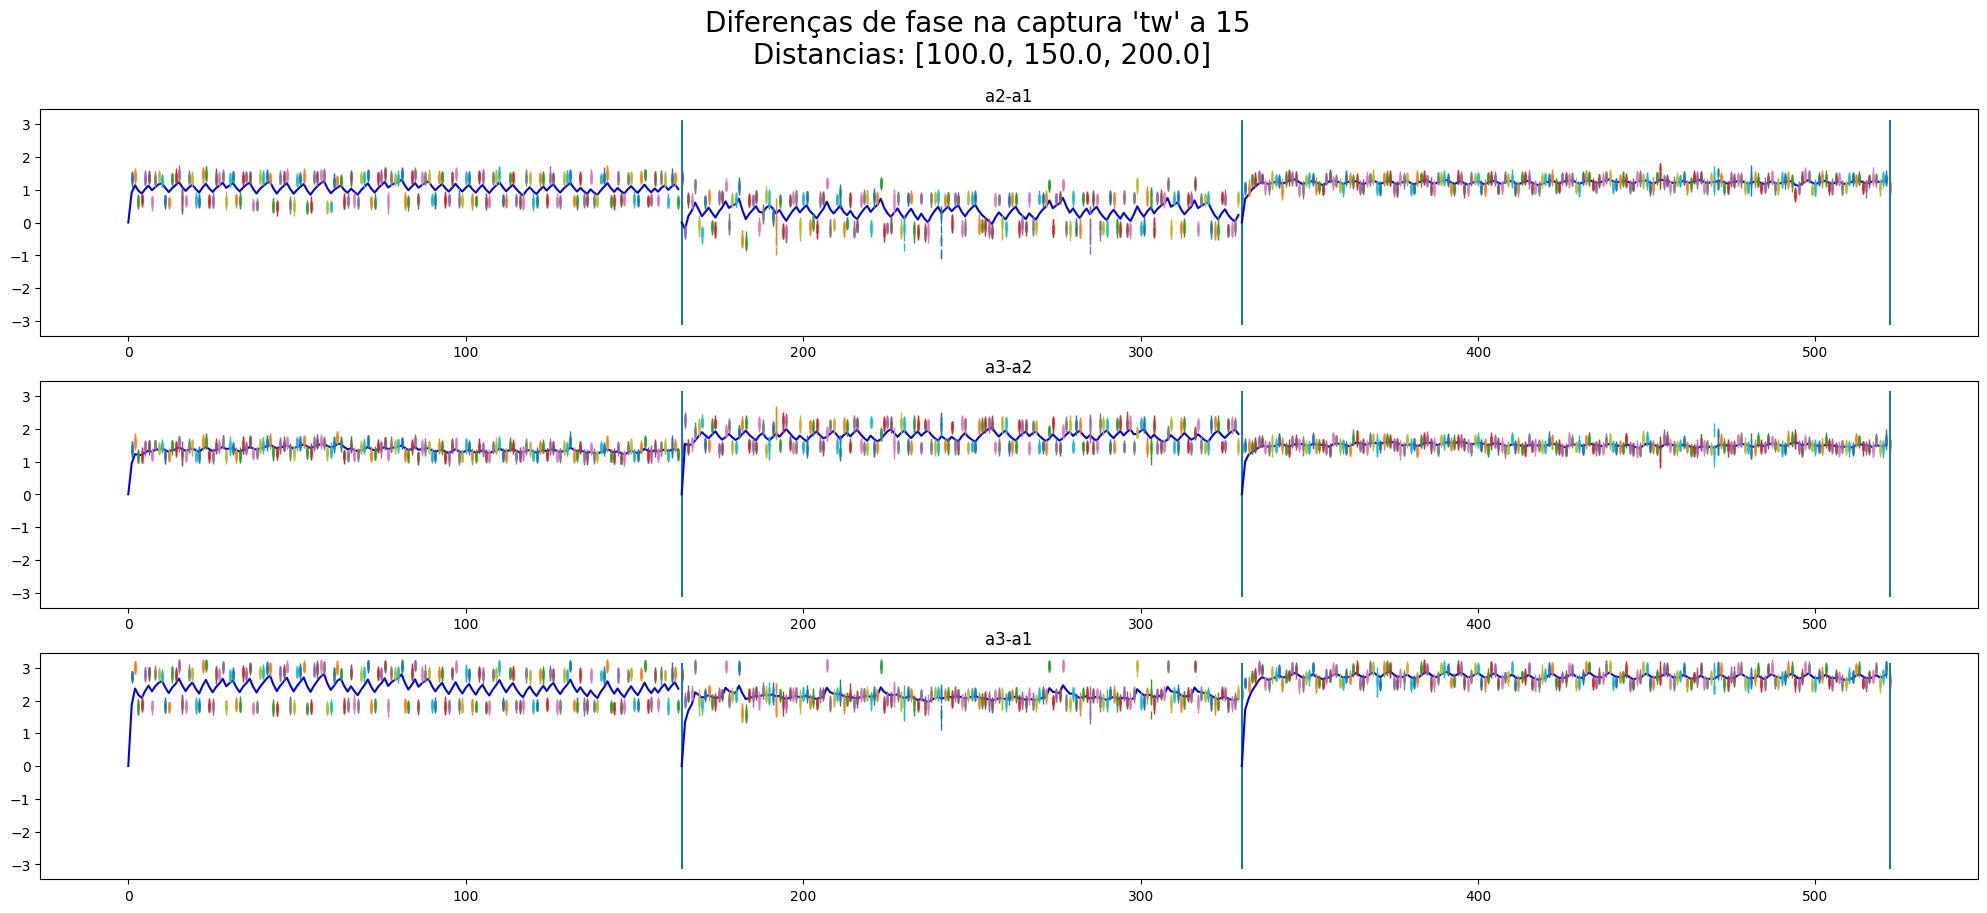

In [4]:

angles = list(set(ds["angle"]))
angles.sort()
angle=15#angles[2]

distances= list(set(ds[ds["angle"] ==  angle]["distance"]))
distances.sort()

#fig, ax =plt.subplots(3,len(distances),figsize=(40,10))
fig, ax =plt.subplots(3,1,figsize=(25,10))

ax[0].set_title("a2-a1")
ax[1].set_title("a3-a2")
ax[2].set_title("a3-a1")

index=0
for row, distance in enumerate(distances):
    kf1 = KalmanFilter(F = F, H = H, Q = Q, R = R)
    p1 = []
    for sample in ds[ds["angle"] ==  angle][ds["distance"] == distance].iterrows():
        p1.append(np.dot(H,kf1.predict((0,0,0)))[0])
        kf1.update((np.mean(sample[1]["a2a1"]),np.mean(sample[1]["a3a2"]),np.mean(sample[1]["a3a1"])))

    ax[0].plot(np.arange(index,index+len(p1)),[p1[a][0] for a in range((len(p1)))],"b-") 
    ax[1].plot(np.arange(index,index+len(p1)),[p1[a][1] for a in range((len(p1)))],"b-") 
    ax[2].plot(np.arange(index,index+len(p1)),[p1[a][2] for a in range((len(p1)))],"b-") 

    
    for i,sample in enumerate(ds[ds["angle"] ==  angle][ds["distance"] == distance].iterrows()):
        index+=1
        #ax[0].plot([index]*len(sample[1]["a2a1"]),sample[1]["a2a1"],"k") 
        ax[0].plot([index]*len(sample[1]["a2a1"]),sample[1]["a2a1"],"|") 

        ax[1].plot([index]*len(sample[1]["a3a2"]),sample[1]["a3a2"],"|") 

        ax[2].plot([index]*len(sample[1]["a3a1"]),sample[1]["a3a1"],"|")



    ax[0].vlines(index,-np.pi,np.pi,label=distance)
    ax[1].vlines(index,-np.pi,np.pi,label=distance)
    ax[2].vlines(index,-np.pi,np.pi,label=distance)

fig.suptitle(f"Diferenças de fase na captura '{cap}' a {angle}\n Distancias: {distances}",size=20)


C:\Users\pedro\AppData\Local\Temp\ipykernel_3804\2857911760.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for sample in ds[ds["angle"] ==  angle][ds["distance"] == distance]["a2a1"]:
C:\Users\pedro\AppData\Local\Temp\ipykernel_3804\2857911760.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for sample in ds[ds["angle"] ==  angle][ds["distance"] == distance]["a3a2"]:
C:\Users\pedro\AppData\Local\Temp\ipykernel_3804\2857911760.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for sample in ds[ds["angle"] ==  angle][ds["distance"] == distance]["a3a1"]:
C:\Users\pedro\AppData\Local\Temp\ipykernel_3804\2857911760.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,sample in enumerate(ds[ds["angle"] ==  angle][ds["distance"] == distance].iterrows()):


Text(0.5, 0.98, "Diferenças de fase na captura 'tw' a 15\n Distancias: [100.0, 150.0, 200.0]")

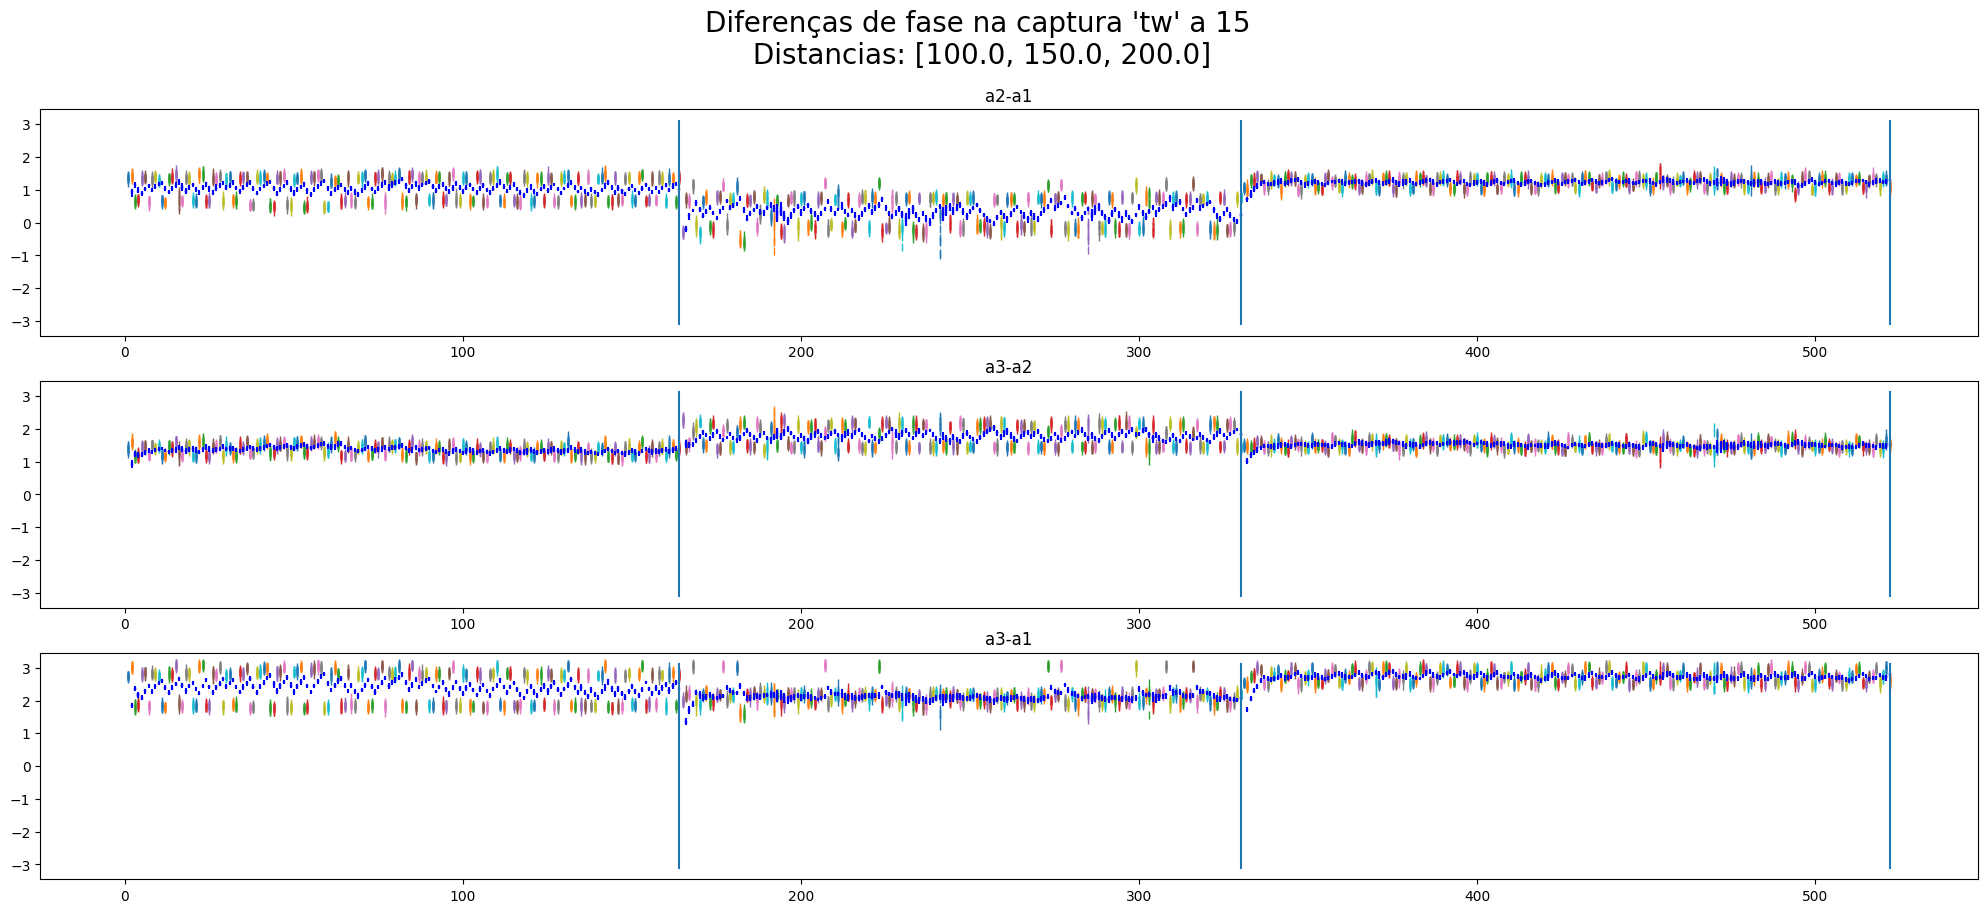

In [ ]:

angles = list(set(ds["angle"]))
angles.sort()
angle=15#angles[2]

distances= list(set(ds[ds["angle"] ==  angle]["distance"]))
distances.sort()

#fig, ax =plt.subplots(3,len(distances),figsize=(40,10))
fig, ax =plt.subplots(3,1,figsize=(25,10))

ax[0].set_title("a2-a1")
ax[1].set_title("a3-a2")
ax[2].set_title("a3-a1")

index=0
for row, distance in enumerate(distances):
    kf1 = KalmanFilter(F = F, H = H, Q = Q, R = R)
    p1 = []
    for sample in ds[ds["angle"] ==  angle][ds["distance"] == distance]["a2a1"]:
        p1.append(np.dot(H,kf1.predict())[0])
        kf1.update(sample)

    kf2 = KalmanFilter(F = F, H = H, Q = Q, R = R)
    p2 = []
    for sample in ds[ds["angle"] ==  angle][ds["distance"] == distance]["a3a2"]:
        p2.append(np.dot(H,kf2.predict())[0])
        kf2.update(sample)

    kf3 = KalmanFilter(F = F, H = H, Q = Q, R = R)
    p3 = []
    for sample in ds[ds["angle"] ==  angle][ds["distance"] == distance]["a3a1"]:
        p3.append(np.dot(H,kf3.predict())[0])
        kf3.update(sample)

    
    for i,sample in enumerate(ds[ds["angle"] ==  angle][ds["distance"] == distance].iterrows()):
        index+=1
        #ax[0].plot([index]*len(sample[1]["a2a1"]),sample[1]["a2a1"],"k") 
        ax[0].plot([index]*len(sample[1]["a2a1"]),sample[1]["a2a1"],"|") 
        ax[0].plot([index]*len(p1[i]),p1[i],"b-") 

        ax[1].plot([index]*len(sample[1]["a3a2"]),sample[1]["a3a2"],"|") 
        ax[1].plot([index]*len(p2[i]),p2[i],"b-") 

        ax[2].plot([index]*len(sample[1]["a3a1"]),sample[1]["a3a1"],"|")
        ax[2].plot([index]*len(p3[i]),p3[i],"b-") 

    ax[0].vlines(index,-np.pi,np.pi,label=distance)
    ax[1].vlines(index,-np.pi,np.pi,label=distance)
    ax[2].vlines(index,-np.pi,np.pi,label=distance)

fig.suptitle(f"Diferenças de fase na captura '{cap}' a {angle}\n Distancias: {distances}",size=20)
